# AKQA Take Home Test Answers

Tim Bearden

February 17, 2017

## Introduction/Pre-processing

Loading the relevant libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Reading in the Data:

In [2]:
df = pd.read_excel('AKQA_Dataset_Test.xlsx', sheetname='Twin Cities')
zips = pd.read_excel('AKQA_Dataset_Test.xlsx', sheetname='Zips')

Some basic examination of the data:

In [3]:
df.shape

(1111, 21)

In [4]:
df.columns

Index([u'ID', u'ADDRESS', u'CITY', u'STATE', u'ZIP', u'ListPrice', u'BEDS',
       u'BATHS', u'LOCATION', u'SQFT', u'LotSize', u'YearBuilt',
       u'ParkingSpots', u'HasGarage', u'DOM', u'LastSaleDate', u'SoldPrev',
       u'Realty', u'LATITUDE', u'LONGITUDE', u'ShortSale'],
      dtype='object')

In [5]:
df.head()

,ID,ADDRESS,CITY,STATE,ZIP,ListPrice,BEDS,BATHS,LOCATION,SQFT,...,YearBuilt,ParkingSpots,HasGarage,DOM,LastSaleDate,SoldPrev,Realty,LATITUDE,LONGITUDE,ShortSale
0,4416206,1000 Larpenteur Ave W,St. Paul,MN,55113,214000,3,2.00,Como,1954,...,1918,2,Garage,117,2008-10-06,Y,"Edina Realty, Inc.",44.991634,-93.142616,N
1,4423768,1004 Charles Ave,St. Paul,MN,55104,134900,3,1.00,Thomas-Dale (Frogtown),1028,...,1911,1,Garage,93,2010-11-08,Y,Fish MLS Realty,44.957291,-93.142624,N
2,4427963,1004 Euclid St,St. Paul,MN,55106,129722,4,1.00,Dayton's Bluff,1420,...,1900,0,No Garage,77,NaT,N,Coldwell Banker Burnet,44.954708,-93.057976,N
3,4432178,1005 Saint Anthony Ave,St. Paul,MN,55104,134900,2,1.75,Summit-University,904,...,1928,3,Garage,57,NaT,N,"Real Estate Masters, Ltd.",44.952404,-93.142693,N
4,4440070,100X Chatsworth Pl,Shoreview,MN,55126,444900,4,2.50,Shoreview,2014,...,2014,3,Garage,8,NaT,N,Coldwell Banker Burnet,44.944391,-93.141348,N


In [6]:
zips.head()

,ZipCode,Population_2010_Census
0,1001,16769
1,1002,29049
2,1003,10372
3,1005,5079
4,1007,14649


After looking through, I decided to do several things to clean this data:
- Added an `Age` column, based on advice in the documentation
- Dropped the `LastSaleDate` column, based on advice in the documentation
- Dropped the `LOCATION`, `LONGITUDE`, and `LATITUDE` variables
- Changed binary classfiers from unicode strings into numeric values (to make them easier to deal with later)
- Dropped the null values

I dropped the three location variables because they would require too much processing (i.e. binning lat/lon in different ways, working with any text errors in the `LOCATION` field, etc.) to be of use, and I assumed that most of the signal contained in those variables would likely be found in the `ZIP` variable anyways. With more time, I would probably do more to work with these variables though.

I dropped the missing values as opposed to filling them in due to time constraints. Since missing values appeared in mostly in one column (`LotSize`), and there weren't too many of them (~6% of total observations), it didn't seem like too much of a sacrifice to get rid of them.

If I had more time, I would have looked into filling `LotSize` through some method like using the median lot size of that property's Zip Code, or maybe using a regression output that predicts lot size based on square footage. Using a straight median fill seems a little too naive, as lot sizes are highly skewed and vary pretty widely by region.

In [7]:
from work import cleaning_data #A function to clean the data in the manner described
df = cleaning_data(df, dropna = True)

In [8]:
df.head()

,ID,ADDRESS,CITY,STATE,ZIP,ListPrice,BEDS,BATHS,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,SoldPrev,Realty,ShortSale,Age
0,4416206,1000 Larpenteur Ave W,St. Paul,MN,55113,214000,3,2.00,1954,6969.0,1918,2,1,117,1,"Edina Realty, Inc.",0,96
1,4423768,1004 Charles Ave,St. Paul,MN,55104,134900,3,1.00,1028,4356.0,1911,1,1,93,1,Fish MLS Realty,0,103
2,4427963,1004 Euclid St,St. Paul,MN,55106,129722,4,1.00,1420,5227.0,1900,0,0,77,0,Coldwell Banker Burnet,0,114
3,4432178,1005 Saint Anthony Ave,St. Paul,MN,55104,134900,2,1.75,904,8712.0,1928,3,1,57,0,"Real Estate Masters, Ltd.",0,86
4,4440070,100X Chatsworth Pl,Shoreview,MN,55126,444900,4,2.50,2014,12632.0,2014,3,1,8,0,Coldwell Banker Burnet,0,0


In [9]:
df.shape

(1046, 18)

In [10]:
df.columns

Index([          u'ID',      u'ADDRESS',         u'CITY',        u'STATE',
                u'ZIP',    u'ListPrice',         u'BEDS',        u'BATHS',
               u'SQFT',      u'LotSize',    u'YearBuilt', u'ParkingSpots',
          u'HasGarage',          u'DOM',     u'SoldPrev',       u'Realty',
          u'ShortSale',          u'Age'],
      dtype='object')

## Question 1

##### You are home developer looking to partner with the top real estate companies to acquire and then sell a large volume of properties in the Twin Cities area (the more the better). You do not have the resources to manage too many real estate partners and a strict timeline to negotiate the deals. 
##### What realty companies would you pick as your partners? Why would you make that choice? Demonstrate this through analysis, visual display of your results, and description of your methodology of selection.

As we can see, there are a lot of different Realty companies. 

In [11]:
len(df.Realty.unique())

204

Since we want to sell a large volume of properties, let's look at just the top 20 Realty companies as measured by the number of listings available:

In [12]:
top_cos = df.groupby('Realty').count().ID.sort_values(ascending=False)[:20]
top_cos

Realty
RE/MAX Results                                      178
Coldwell Banker Burnet                              156
Edina Realty, Inc.                                  145
Keller Williams Premier Realty                       27
RE/MAX Specialists                                   24
RE/MAX Advantage Plus                                24
Keller Williams Integrity RE                         22
Keller Williams Integrity                            22
The Realty House                                     14
Keller Williams Classic Realty NW                    13
Counselor Realty, Inc                                13
Counselor Realty, Inc.                               11
Lakes Sotheby's International                         9
Better Homes and Gardens Real Estate-All Seasons      9
Re/Max Prodigy                                        8
Talbot Realty                                         8
DeLisle Company, Inc.                                 7
The Ewing Group, LLC                     

There appears to be a pretty quick drop off in terms of available listings. Since we probably wouldn't want to deal with any Real Estate company that has very few listings anyways, it is probably safe to limit our search to companies with at least 10 listings. Since several of these companies appear to have the same parent company, I will assume that companies with different labels are different companies, regardless of whether they are owned by the same parent corp (e.g. I treat RE/MAX Specialists as different from RE/MAX Advantage Plus). 

In [13]:
top_cos = top_cos[top_cos >= 10]
top_df = df[df['Realty'].isin(top_cos.index)]

Now, we'll want to consider a few things as we pick a Real Estate company to work with:
- Average listing price of the company (we want large profit margins)
- Average number of days on the market (we want to sell quickly)
- What percent of properties with each company has sold previously? (we want houses to sell well)
- What percent of properties with each company are short sales? (we don't want the complications of buying short)

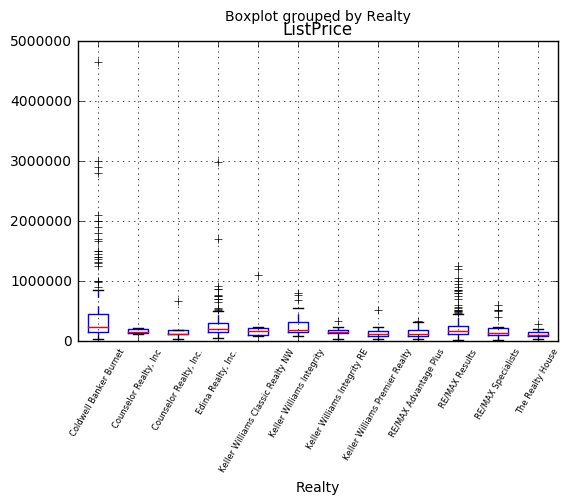

In [14]:
top_df.boxplot('ListPrice', by = 'Realty', fontsize = 6, rot = 60)

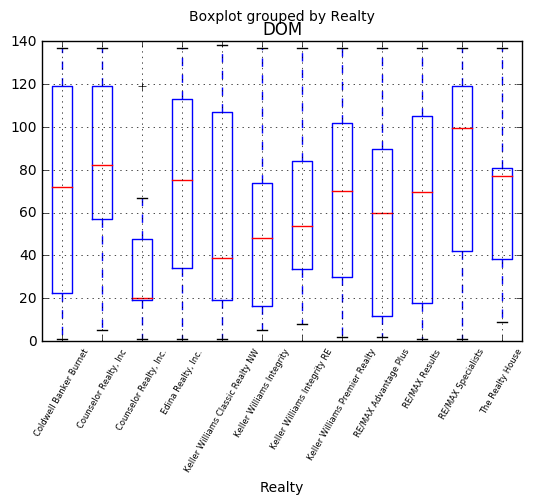

In [15]:
top_df.boxplot('DOM', by = 'Realty', fontsize = 6, rot = 60)

In [16]:
top_df.groupby('Realty').mean()[['SoldPrev', 'ShortSale']]

,SoldPrev,ShortSale
Realty,,
Coldwell Banker Burnet,0.301282,0.044872
"Counselor Realty, Inc",0.307692,0.076923
"Counselor Realty, Inc.",0.181818,0.000000
"Edina Realty, Inc.",0.241379,0.068966
Keller Williams Classic Realty NW,0.615385,0.384615
Keller Williams Integrity,0.363636,0.045455
Keller Williams Integrity RE,0.590909,0.045455
Keller Williams Premier Realty,0.222222,0.037037
RE/MAX Advantage Plus,0.250000,0.000000


**Coldwell Banker Burnet**, **Edina Realty**, and **RE/MAX Results** all have many listings, each with several high value listings. Examining the `DOM` boxplots (days on market) doesn't show any drastic differences between the companies, and the percentages of listings that had been sold previously and that were short sales don't seem outstanding in any negative way. Thus, I would recommend that we partner with those three companies.

## Question 2

##### All things being equal what would you predict as the listing price for a 2111 square foot house if that was the only information you had on a house in this area? How did you arrive at that estimate? Please explain.

For this problem, I will use a linear regression model to estimate the value of a house:

In [17]:
import statsmodels.api as sm

Let's start off with a model that predicts list price solely on square footage. 

In [18]:
y = df['ListPrice']
X = df['SQFT']

To see if they actually have a linear relationship:

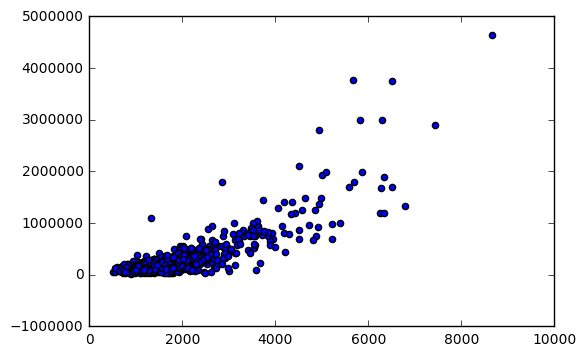

In [19]:
plt.scatter(X, y)

The variables don't quite look like they have a linear relationship, so let's look at what happens when we plot the logged variables:

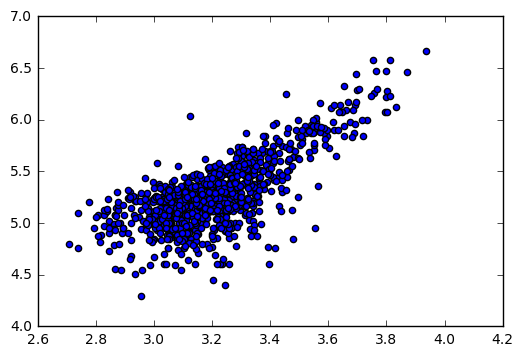

In [20]:
plt.scatter(np.log10(X), np.log10(y))

That looks a little better. Let's try building a simple model and see how it does.

In [21]:
y = np.log10(y)
X = sm.add_constant(np.log10(X))
model = sm.OLS(y, X)
results = model.fit()

In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ListPrice   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     1280.
Date:                Fri, 17 Feb 2017   Prob (F-statistic):          1.32e-183
Time:                        09:39:37   Log-Likelihood:                 94.322
No. Observations:                1046   AIC:                            -184.6
Df Residuals:                    1044   BIC:                            -174.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1085      0.117      9.501      0.000       0.880       1.337
SQFT           1.2992      0.036     35.775      0.000       1.228       1.370
==============================================================================
Omnibus:                       78.075   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.521
Skew:                          -0.561   Prob(JB):                     2.48e-27
Kurtosis:                       4.246   Cond. No.                         60.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The effect is statistically significant, and the regresssion has a solid R^2 value for a univariate regression (~55% of the variation in logged listing prices can be explained by the logged square footage). Doing some analysis of the residuals:

(array([   7.,   12.,   39.,  104.,  282.,  338.,  223.,   36.,    4.,    1.]),
 array([-0.92001424, -0.74074282, -0.56147141, -0.3822    , -0.20292858,
        -0.02365717,  0.15561425,  0.33488566,  0.51415707,  0.69342849,
         0.8726999 ]),
 <a list of 10 Patch objects>)

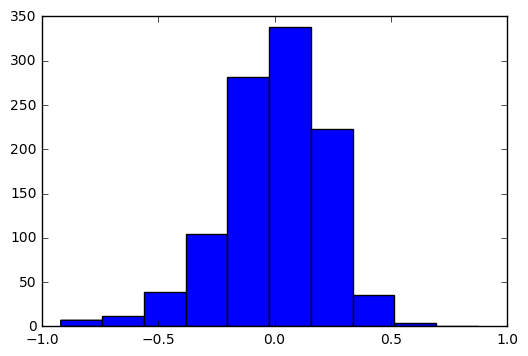

In [23]:
residuals = results.resid
plt.hist(residuals)

The residuals appear fairly normally distributed.

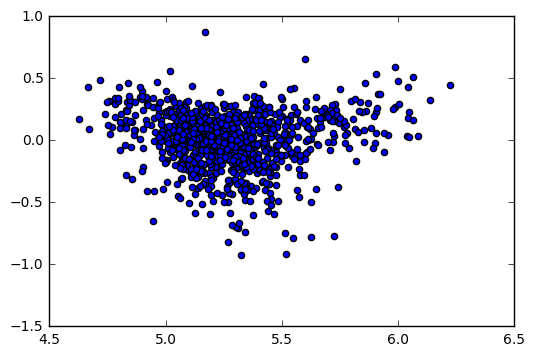

In [24]:
predictions = results.predict()
plt.scatter(predictions, residuals)

There doesn't appear to be any high degree of heteroskedasticity in the residuals either. With a high R^2 and no outstanding issues, this model should suffice to make a decent prediction. 

In [25]:
10**(results.params['const'] + results.params['SQFT'] * np.log10(2111))

267711.3606777676

The cost of a property in this area with a 2111 square foot house on it would be approximately $267,711.36, according to this simple model.

## Question 3

##### Imagine you are an enterprising real estate agent who has the chance to buy up a bundle of houses for sale – but you can only pick one zip code (either 55104 or 55108). 
##### Also, you can only buy a bundle of properties priced within the middle 50% of the values – you won’t be able to buy the most expensive houses or the cheapest houses. 
##### Assume the sample of houses in this dataset is representative for those zip codes. If you had the choice to buy 1000 homes in either 55104 or 55108 which zip code would you invest in and why? Provide your analysis and reasoning.

Let's start by subsetting our data frame to just these two zip codes and see many observations are left.

In [26]:
two_codes = df[(df['ZIP'] == 55104) | (df['ZIP'] == 55108)]
two_codes.shape

(89, 18)

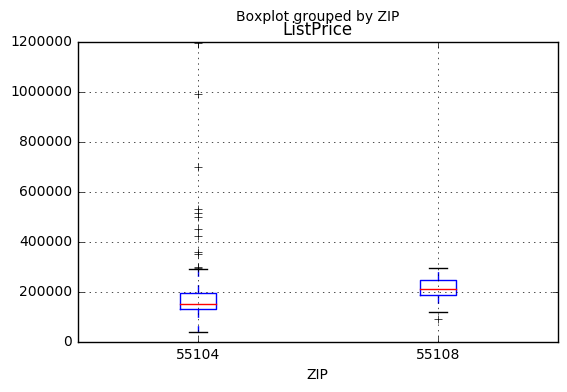

In [27]:
two_codes.boxplot('ListPrice', by = 'ZIP')

Right off the bat we can see that 55108 has slightly more expensive real estate in its middle 50%. Let's take a deeper look at what the properties look like in each zip code's middle 50%.

In [28]:
bounds = two_codes.groupby('ZIP').describe().ListPrice

#Creating a dataframe for each zip code's middle 50%
sub_mask = (two_codes['ZIP'] == 55104) & (two_codes['ListPrice'] >= bounds[55104]['25%']) & (two_codes['ListPrice'] <= bounds[55104]['75%'])
middle4 = two_codes[sub_mask]

sub_mask = (two_codes['ZIP'] == 55108) & (two_codes['ListPrice'] >= bounds[55108]['25%']) & (two_codes['ListPrice'] <= bounds[55108]['75%'])
middle8 = two_codes[sub_mask]

In [29]:
middle4.describe().drop('ListPrice', axis=1)

,ZIP,BEDS,BATHS,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,SoldPrev,ShortSale,Age
count,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000
mean,55104.0,3.189189,1.385135,1368.000000,5013.675676,1915.945946,1.891892,0.918919,78.702703,0.459459,0.0,98.054054
std,0.0,0.876795,0.466200,311.441095,1386.232746,23.421199,1.074549,0.276725,42.899666,0.505228,0.0,23.421199
min,55104.0,1.000000,0.750000,784.000000,1001.000000,1886.000000,0.000000,0.000000,1.000000,0.000000,0.0,10.000000
25%,55104.0,3.000000,1.000000,1127.000000,4791.000000,1900.000000,1.000000,1.000000,50.000000,0.000000,0.0,93.000000
50%,55104.0,3.000000,1.250000,1369.000000,4791.000000,1911.000000,2.000000,1.000000,86.000000,0.000000,0.0,103.000000
75%,55104.0,4.000000,1.750000,1600.000000,4791.000000,1921.000000,2.000000,1.000000,106.000000,1.000000,0.0,114.000000
max,55104.0,5.000000,2.750000,1932.000000,9888.000000,2004.000000,5.000000,1.000000,137.000000,1.000000,0.0,128.000000


In [30]:
middle8.describe().drop('ListPrice', axis=1)

,ZIP,BEDS,BATHS,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,SoldPrev,ShortSale,Age
count,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000
mean,55108.0,2.714286,1.357143,1487.571429,5040.142857,1925.000000,1.285714,1.0,69.000000,0.142857,0.142857,89.000000
std,0.0,0.487950,0.349319,283.274224,233.051803,9.521905,0.487950,0.0,46.946778,0.377964,0.377964,9.521905
min,55108.0,2.000000,1.000000,1072.000000,4791.000000,1906.000000,1.000000,1.0,8.000000,0.000000,0.000000,80.000000
25%,55108.0,2.500000,1.000000,1332.000000,4791.000000,1923.000000,1.000000,1.0,41.500000,0.000000,0.000000,83.000000
50%,55108.0,3.000000,1.500000,1401.000000,5227.000000,1927.000000,1.000000,1.0,68.000000,0.000000,0.000000,87.000000
75%,55108.0,3.000000,1.625000,1720.500000,5227.000000,1931.000000,1.500000,1.0,93.500000,0.000000,0.000000,91.000000
max,55108.0,3.000000,1.750000,1835.000000,5227.000000,1934.000000,2.000000,1.0,137.000000,1.000000,1.000000,108.000000


It's hard to say too much about the properties in 55108 because it's a small sample size, however it seems like the properties here are more consistent. The properties are all consistently older and while there aren't any houses that seem to be outstanding in terms of size and amenities, they all seem to be of quality (every single house has a garage, for example). I would guess that this is a more suburban, family-type area. This would be a good zip code to invest in for a dependable investment.

55104 seems to have much more variation. Everything's cheaper, and while many houses are smaller and have fewer amenities, there's a chance you can get a much bigger and more complete house than anything you can find in 55108. A lot of places are old, but there are younger structures than anything in 55108 as well. I would guess that this is probably somewhere closer downtown, that could have the potential to go through some sort of revitalization process. This would be the zip code to invest in that could be more high-risk, high-reward.

Ultimately, which zip code to invest in would depend on the investor's tolerance for risk. Since I'm at a point in my life where I can probably handle riskier, higher growth opportunities, I would probably buy property in 55104.

## Question 4

##### We’re looking to understand what features of the home are most important to potentially predicting the list price of a house. What has the strongest relationship to listing price: square foot, lot size, or number of bedrooms? How do they compare? Please explain.

In [31]:
df[['ListPrice','SQFT', 'LotSize', 'BEDS']].corr()

,ListPrice,SQFT,LotSize,BEDS
ListPrice,1.000000,0.824046,0.259727,0.400118
SQFT,0.824046,1.000000,0.264090,0.638438
LotSize,0.259727,0.264090,1.000000,0.159209
BEDS,0.400118,0.638438,0.159209,1.000000


Just looking at the correlations, square footage seems to have the strongest relationship with list price. We can also take a look at a linear regression with these variables to get a sense as to the magnitude of each variable's effect.

In [32]:
y = df['ListPrice']
X = sm.add_constant(df[['SQFT', 'LotSize', 'BEDS']])

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ListPrice   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     840.4
Date:                Fri, 17 Feb 2017   Prob (F-statistic):          1.35e-277
Time:                        09:39:39   Log-Likelihood:                -14269.
No. Observations:                1046   AIC:                         2.855e+04
Df Residuals:                    1042   BIC:                         2.857e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.283e+05   2.25e+04     -5.704      0.000   -1.72e+05   -8.42e+04
SQFT         366.5132      8.614     42.548      0.000     349.610     383.416
LotSize        2.2067      0.889      2.482      0.013       0.462       3.951
BEDS        -8.41e+04   8635.828     -9.739      0.000   -1.01e+05   -6.72e+04
==============================================================================
Omnibus:                      863.320   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46167.962
Skew:                           3.380   Prob(JB):                         0.00
Kurtosis:                      34.837   Cond. No.                     3.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While this may or may not be a great model to predict with, we can at least see that all three variables do appear to have some sort of effect, and again square footage seems to have the strongest positive effect. 

Since square footage and lot size are both measured in square feet, it's a pretty easy comparison to make: all else constant, each additional square foot of house size increases the list price by around \$366.51 according to the model, while each additional square foot of lot size increases the list price by around $2.20.

The coefficient on number of bedrooms seems curious. According to this model, each additional bedroom should *decrease* the value of the property by around $8410. Perhaps this is indicative of the fact that cramming more bedrooms into a house while keeping the square footage constant might make it less valuable.

With more time, I might look into making better models that would more accurately reflect each variable's effect on list price, but for now, all evidence seems to point to the square footage of the house being the most important.

## Question 5

##### Short sales are sometimes good opportunities to get value for a house but there is also the risk the property will need a lot of work. How do short sales compare on the average square foot of the house, average price per square foot, and the average lot size?
##### Now pivot this data based on the location field. Are short sales always a better deal than regular listings? Can we say with certainty this is true for every location? Why or why not?

In [33]:
shorts = df.groupby('ShortSale').mean()[['ListPrice', 'SQFT', 'LotSize']]
shorts

,ListPrice,SQFT,LotSize
ShortSale,,,
0,282544.497955,1808.618609,6714.119632
1,143339.970588,1510.073529,6347.779412


Short sale houses tend to be moderately smaller, but have much lower prices.

## Question 6

##### We’d like to understand how listings compare with the population in their area. Take the zip code data in the 2nd sheet and match against the house listing data. What zip codes have the highest amount of listings per the population size? Show the top 10.
##### Separately, what zip code has the highest listing price per person? Google that zip code and provide some hypothesis and examples as to why this might be true.

In [34]:
zip_listings = pd.DataFrame(df.groupby('ZIP').count().ID)
zip_pop = pd.merge(zip_listings, zips, left_index = True, right_on = 'ZipCode', how = 'left')
zip_pop['ListingsPerCap'] = zip_pop['ID'] / zip_pop['Population_2010_Census']
zip_pop.sort_values('ListingsPerCap', ascending=False)[:10]

,ID,ZipCode,Population_2010_Census,ListingsPerCap
18509,98,55412,22148,0.004425
18507,54,55410,19340,0.002792
18385,123,55106,52730,0.002333
18514,55,55417,24875,0.002211
18516,58,55419,26406,0.002196
18503,67,55406,32112,0.002086
18386,30,55107,14776,0.002030
18395,44,55116,23851,0.001845
18384,49,55105,28455,0.001722
18383,74,55104,43248,0.001711


"Highest listing price per person" is a little vague, so I interpreted it to mean the zip code with the highest total value listed (sum of listings) divided by the population. 

In [35]:
mean_prices = pd.DataFrame(df.groupby('ZIP').sum().ListPrice)
price_pop = pd.merge(mean_prices, zips, left_index = True, right_on = 'ZipCode', how = 'left')
price_pop['PricePerCap'] = price_pop['ListPrice'] / price_pop['Population_2010_Census']
price_pop.sort_values('PricePerCap', ascending=False).head(1)

,ListPrice,ZipCode,Population_2010_Census,PricePerCap
18507,44256911,55410,19340,2288.361479


## Question 7

##### You’ve just been hired as a data scientist at the premier real estate firm in this area. They want to forecast the actual sales price for any of these listings (and future listings).
##### What variables from this example data do you think would be the most predictive of the actual sales price? What other kinds of data would you want have to provide the most accurate prediction of the actual sales price? 
##### Assume you can get any data you want. Describe this data clearly and why you think it would help you build an accurate predictive model.

Square footage has shown up repeatedly as a strong predictor of list price in this analysis. Let's take a look at a more extended version of the correlation matrix I used in Question 4 to examine the strength of each variable.

In [36]:
df.corr().drop(['ZIP', 'YearBuilt'], axis=1)

,ListPrice,BEDS,BATHS,SQFT,LotSize,ParkingSpots,HasGarage,DOM,SoldPrev,ShortSale,Age
ZIP,0.134766,-0.047141,0.038006,0.063614,-0.082407,-0.035227,0.111740,-0.052629,0.063294,-0.001799,-0.129239
ListPrice,1.000000,0.400118,0.707850,0.824046,0.259727,0.241954,0.076656,0.129564,-0.021497,-0.091242,-0.227587
BEDS,0.400118,1.000000,0.619517,0.638438,0.159209,0.195976,0.031157,0.024844,0.058530,-0.095143,-0.173837
BATHS,0.707850,0.619517,1.000000,0.839280,0.203692,0.284886,0.096358,0.074581,0.039459,-0.067862,-0.310650
SQFT,0.824046,0.638438,0.839280,1.000000,0.264090,0.306510,0.068392,0.116635,-0.030727,-0.075655,-0.236926
LotSize,0.259727,0.159209,0.203692,0.264090,1.000000,0.141243,0.047955,0.074528,-0.085887,-0.012288,-0.026312
YearBuilt,0.227587,0.173837,0.310650,0.236926,0.026312,0.081422,0.168421,-0.013302,0.071662,-0.030976,-1.000000
ParkingSpots,0.241954,0.195976,0.284886,0.306510,0.141243,1.000000,0.281160,0.032527,-0.021059,-0.025773,-0.081422
HasGarage,0.076656,0.031157,0.096358,0.068392,0.047955,0.281160,1.000000,-0.009998,-0.019169,0.013296,-0.168421
DOM,0.129564,0.024844,0.074581,0.116635,0.074528,0.032527,-0.009998,1.000000,-0.077773,0.110658,0.013302


Again, square footage seems important, as does the number of bedrooms, number of bathrooms, lot size, parking spots, age, and days on the market. These all make sense as things that would affect the price of a house, as they are almost all directly tied to the quality of the house. The one variable that is not directly tied to what the house is like is days on the market, but that makes sense as a predictor as well. If it has been on the market for a long time, it was probably overpriced to start, and they've had to drop the price to draw in prospective buyers.

I think those variables all do a good job of covering what features of a house make it valuable, so if I were to look for outside information it would probably be to look at market conditions. For example, areas with higher income levels and lower unemployment will likely have more expensive houses. Macroeconomic conditions would probably also be good to look at; recessions would probably drive list prices down.

I would also want to look at historical price listings, to see if there is any cyclicality in the way that house prices are listed. I would imagine certain times of year are better than others to buy houses, so having data that could show that would be valuable as well. 